<a href="https://colab.research.google.com/github/tsxepo-web/AbstractFactoryDemo/blob/main/CharacterClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'az-handwritten-alphabets-in-csv-format:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F9726%2F17999%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240206%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240206T153719Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1c18349b46f2572577d2d80655d8c7c41cc3278a3196f5ada35f177b3837b289f7e2ca9904bc849f1a6f80ff8cfd165266beeee2b620255b9e579b09a500abf09c700c0b4040765d581e4211a06ab50e1ea2d235061ba916688512c6750cb9c2996f6b7dcb81cc82d4d8241300c3fb655c24e7616e55343e63b93cc32ffbb452dbb32e4c8506429b3cee10622f40e0e1cd81e2ebe3359df2f998e5b854f839d6cd947d2cd049537cfddfdec8891f12537e61cb7befda516e380220ab725bce960edce7ec19f3b7665944d7486ebc16a7b2b7772b64363772a93846379502a698bd98a0d75de98221102458f52d3cafcda5286190a4430fbf4a82d3e267ca7281'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 193643888 bytes downloaded
Downloaded and uncompressed: az-handwritten-alphabets-in-csv-format
Data source import complete.


In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv
/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data/A_Z Handwritten Data.csv


In [47]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [48]:
data = pd.read_csv('/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data/A_Z Handwritten Data.csv').astype('float32')
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
data.tail()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
372445,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372446,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372447,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372448,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372449,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
X = data.drop('0', axis = 1)
y = data['0']

In [51]:
X.head()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 0, dtype: float32

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2)
X_train = np.reshape(X_train.values, (X_train.shape[0], 28,28))
X_test = np.reshape(X_test.values, (X_test.shape[0], 28,28))
print(X_train.shape)
print(X_test.shape)

(297960, 28, 28)
(74490, 28, 28)


In [54]:
word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}

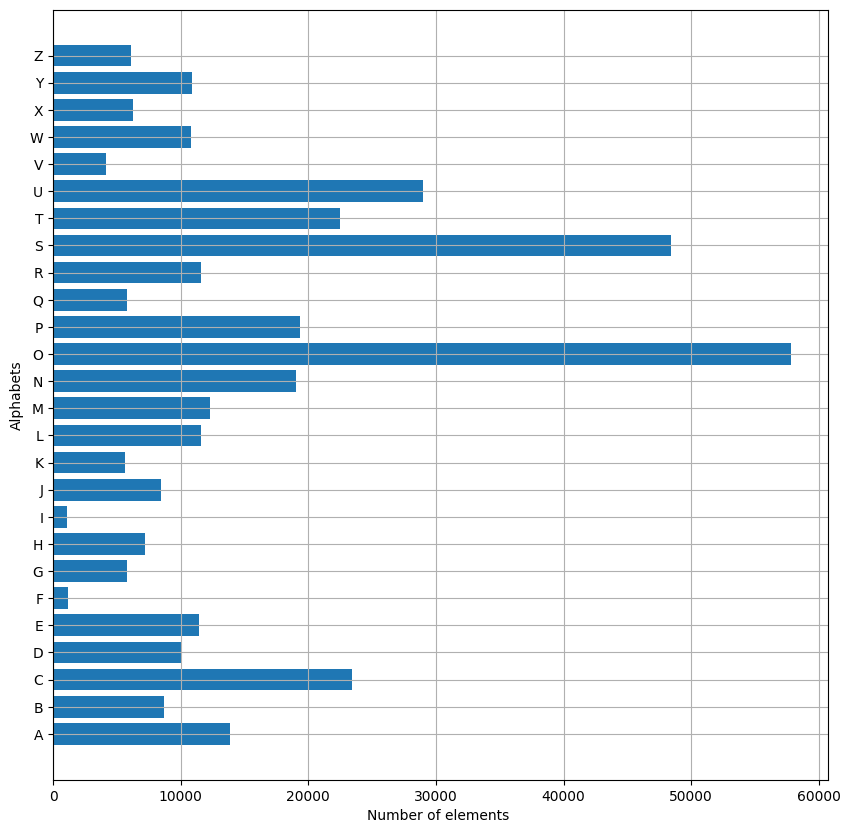

In [55]:
y_int = np.intp(y)
count = np.zeros(26, dtype='int')

for i in y_int:
    count[i] += 1

alphabets = []
for i in word_dict.values():
    alphabets.append(i)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.barh(alphabets, count)

plt.xlabel('Number of elements ')
plt.ylabel('Alphabets')
plt.grid()
plt.show()

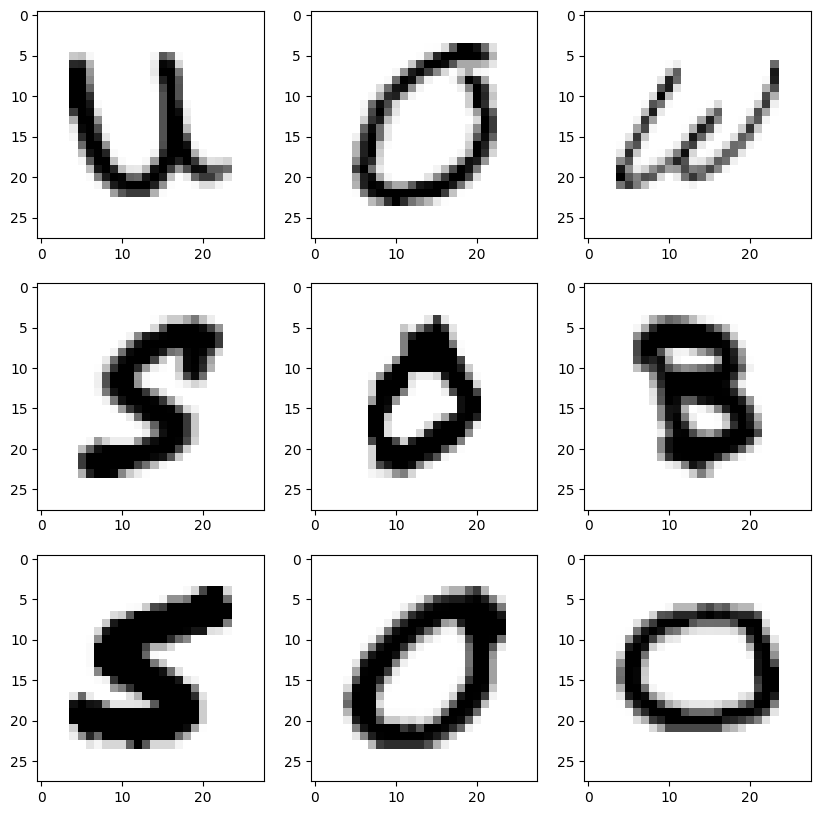

In [56]:
shuff = shuffle(X_train[:100])

fig, ax = plt.subplots(3,3, figsize = (10,10))
axes = ax.flatten()

for i in range(9):
    _, shu = cv2.threshold(shuff[i], 30, 200, cv2.THRESH_BINARY)
    axes[i].imshow(np.reshape(shuff[i], (28,28)), cmap="Greys")
plt.show()

In [57]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_train.shape)
print(X_test.shape)


(297960, 28, 28, 1)
(74490, 28, 28, 1)


In [58]:
train_yOHE = to_categorical(Y_train, num_classes = 26, dtype='int')
test_yOHE = to_categorical(Y_test, num_classes = 26, dtype='int')
print(train_yOHE.shape)
print(test_yOHE.shape)

(297960, 26)
(74490, 26)


In [59]:

selected_image_index = 0  # You can change this index to visualize different images
selected_image = X_train[selected_image_index]

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))


model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())


model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))

model.add(Dense(26,activation ="softmax"))


In [60]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, train_yOHE, epochs=1, validation_data=(X_test, test_yOHE))

9312/9312 [==============================] - 383s 41ms/step - loss: 0.1609 - accuracy: 0.9560 - val_loss: 0.0853 - val_accuracy: 0.9763


In [61]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 13, 13, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 2, 2, 128)       

In [62]:
print("The validation accuracy is :", history.history['val_accuracy'])
print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])

The validation accuracy is : [0.9763323664665222]
The training accuracy is : [0.956027626991272]
The validation loss is : [0.0852862298488617]
The training loss is : [0.16093437373638153]
